# Interactive tutorial: extracellular recordings of neural activity

## Objectives:
- develop an intuitive understanding of the impact of neural activity on the extracellular environment 

The above analysis gives us a good intuition of what an action potential looks like electrically from the inside of a cell. But *what about its extracelluar manifestation?* In other words, ***what will an extracellular spike look like?***

YOUR ANSWER

### Imports

In [1]:
%matplotlib widget
import numpy as np
from stimulus import CurrentPulseTrain
from model import PyramidalNeuron
from simutils import simulate, interactive_extracellular, interactive_extracellular_2neurons
from constants import *

## Recall: the action potential waveform

Let's start where we left things off during the last session, i.e. a cortical pyramidal neuron model with:
- a membrane capacitance ($C_m = 1\ uF/cm^2$)
- a leakage current $i_{Leak}$
- a voltage-gated sodium current $i_{Na}$ (with 3 activation gates *M* and 1 inactivation gate *H*)
- a voltage-gated potassium current $i_K$ (with 4 activation gates *N*)

Its electrical circuit representation is:

![circuit](imgs/circuits-04.png)

And the system's governing equation is:

$$C_m \frac{dV_m}{dt} = i_{stim} - [i_{Leak}(V_m) + i_{Na}(m, V_m) + i_{K}(n, V_m)]$$

which can be summarized as:

$$C_m \frac{dV_m}{dt} = i_{stim} - i_{membrane}(V_m)$$

where $i_{membrane}(V_m)$ represents the total ionic current flowing through the membrane.

As a reminder, this is the neuron's action potential dynamics:

 11/02/2022 14:31:34: simulating model with CurrentPulseTrain(I=50.00uA/cm2, tpulse=0.5ms, npulses=1, PRF=0.10kHz, tstart=0.5ms) stimulus for 5.0 ms...


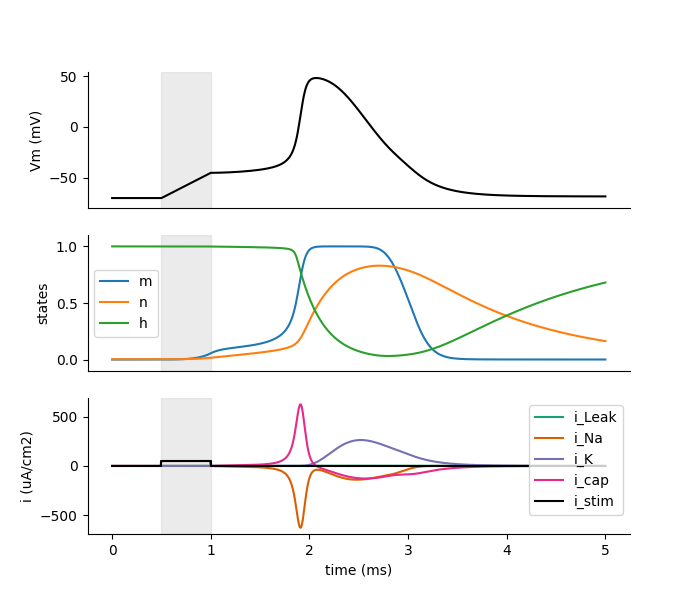

In [2]:
model = PyramidalNeuron()
stim = CurrentPulseTrain(I=50.0, tpulse=.5, tstart=.5)
data = simulate(model, 5., stim=stim, dt=0.01)
fig = data.plot_all(model, stim=stim)

#### Questions
- *According to the graph above, can you describe the main properties of this typical action potential (duration, amplitude, polarity)?*
- *According to the circuit model above, what is the value of the extracellular potential during a spike?*

## The extracellular medium and extracellular potential

In the above simulation, we assume that the extracellular potential is grounded, i.e. $V_{out} = 0$. However, in practice neural activity does influence the extracellular field (in fact that influence can be recorded).

***So what exactly happens to the extracellular field during a spike?***

It turns out that for problems involving frequencies < 3 kHz (such as neural spiking), the extracellular medium is well modeled by an isotropic volume conductor described by a purely ohmic conductivity $σ$ in $(S/m)$. Under these circumstances, the electric potential $φ$ in the extracellular space is governed by Laplace’s equation:

$$∇ \cdot (σ∇φ) = 0$$

The neuron undergoing an action potential can then be considered as a punctual source of current $I_m$ in this extracellular medium, where we have:

$$σ∇φ = I_m$$

That is, the gradient in extracellular potential $∇φ$ is proportional to the membrane current source $I_m$ divided by the medium conductivity $σ$. 

Assuming that extracellular conductivity is isotropic, the problem becomes spherically symmetric, yielding the following solution to the extracellular potential at a distance $r$ from the neuron:

$$φ(r) = \frac{I_m}{4πσr}$$

Tne electrical circuit representation of this extended configuration is:

![circuit](imgs/circuits-05.png)


#### Questions

In light of the above formulae, please comment on:
- *What is the quantity affecting extracellular potential during as spike?*
- *How does extracellular potential depend on distance to the neuron?* 
- *Based on yesterday's lecture, can you list a few limitations in this modeling strategy?* 

### Membrane current

Let's have a closer look at the membrane current during an action potential:

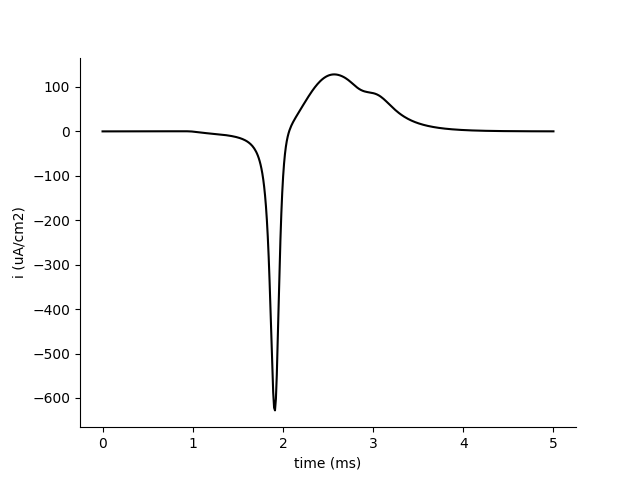

In [3]:
data[CURRENT_DENSITY] = model.i_membrane(data[V_MV], data)
fig = data.plot_var(CURRENT_DENSITY)

### Questions:

- *What can you say about the polarity of the membrane current during a spike?* 
- *What about its unit? What are we actually computing?*

### Membrane area

The membrane current we have computed so far is expressed as a current density (in μA/cm2). We therefore need to convert it to an absolute current source. To do so, we must integrate the current density over the neuron membrane area.

For the sake of simplicity, let's consider the case of an action potential occuring uniformly over the soma of a pyramidal neuron, represented by a sphere of diameter 50 um. 

In [5]:
d = 50. # soma diameter (um)
A = np.pi * d**2 * UM2_TO_CM2  # cm2
print(f'Area = {A:.2e} cm2')

Area = 7.85e-05 cm2


Let's now compute our membrane current:

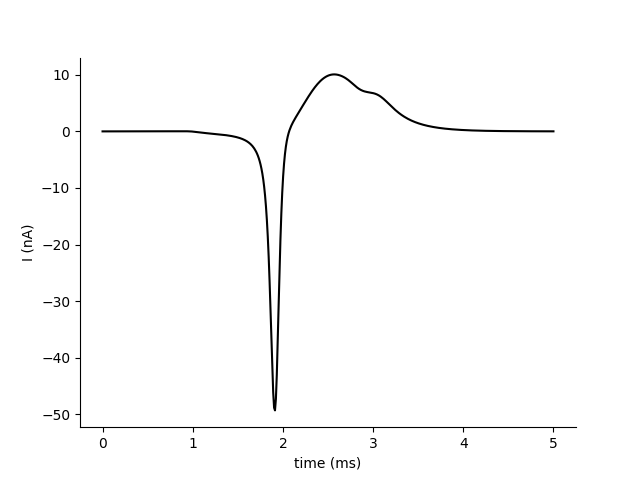

In [6]:
data[I_NA] = data[CURRENT_DENSITY] * A * UA_TO_NA
fig = data.plot_var(I_NA)

#### Questions
- *What do you conclude about the magnitude of a membrane current during a typical action potential?* 

### Extracellular voltage 

Finally, let's compute the extracellular membrane potential at various distances from the neuron

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='r (um)', max=300.0, min=10…

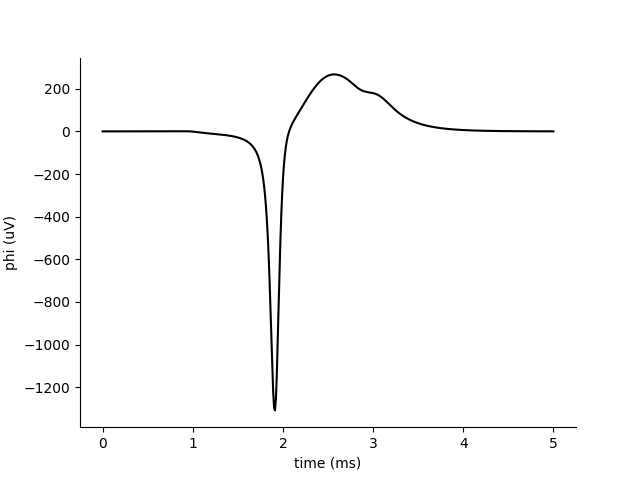

In [7]:
sigma = 0.3  # Grey matter conductivity (S/m)
def phi(I, r):
    return I / (4 * np.pi * sigma * r) * MV_TO_UV

interactive_extracellular(
    data, lambda data, r: phi(data[I_NA], r));

### Questions:

- *What do you conclude about the magnitude of extracellular action potentials?*
- *What is missing from this trace*?

### Intrinsic noise

As you've seen during yesterday's lecture, extracellular voltage recordings are not *perfect*: they are polluted by intrinsic noise at the electrode interface, but also coming from the aggregated electrical activity of neurons outside the region of interest. 

Therefore, in an attempt to get closer to real-world recording conditions, we will add a 20 μV white noise to the extracellular potential coming from our neuron.

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='r (um)', max=300.0, min=10…

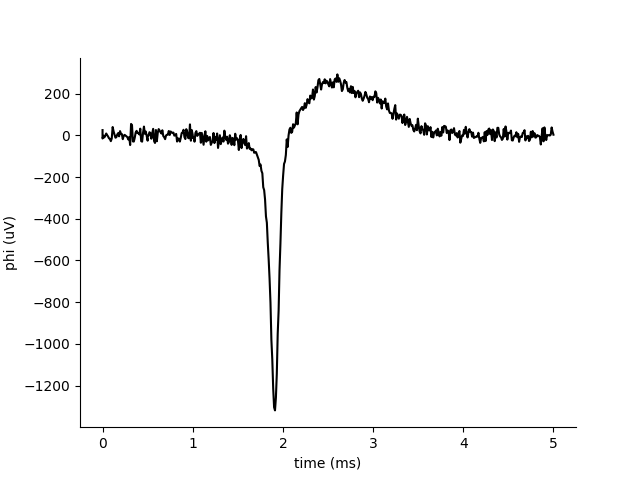

In [8]:
noiseamp = 20.  # uV
baseline = np.random.normal(0., noiseamp, size=len(data))
interactive_extracellular(
    data, lambda data, r: phi(data[I_NA], r) + baseline);

### Questions:

- *What seems to be the maximal distance from which an extracellular spike is still detectable?*

## Multiple neurons

Until now, we've considered the impact of a single neuron on the extracellular potential recorded by an electrode. However in practice, multiple neighboring neurons are contributing to the extracellular potential at the recording site.

As we saw during the course, the linearity of electrical conduction in the extracellular medium implies that the extracellular potential at a specific point can be seen as the sum of contributions from individual current sources (in our case, the neurons). Hence, we will model here the contribution of 2 neurons to the recorded potential.

Output()

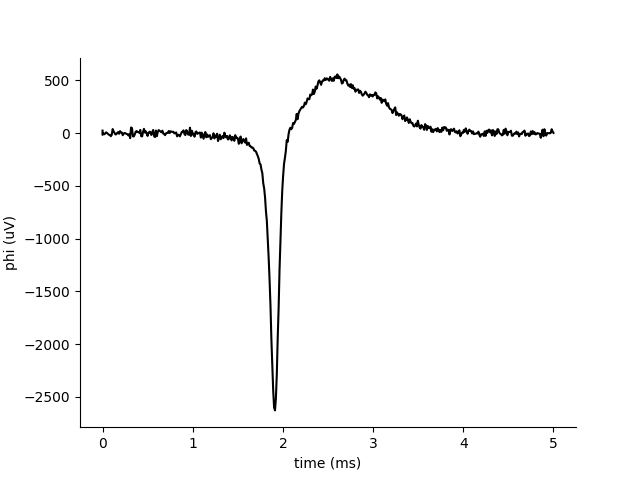

In [9]:
interactive_extracellular_2neurons(data, phi, baseline=baseline);

### Questions:

- *What is the minimum temporal shift with would allow tyou to effectively separate spikes coming from 2 different neurons?*
- *More generally, what can you say about the nature of multi-unit activity traces?*